

# in-silico mutagenisis using a tensorflow model and preparation of files for tf modisco-lite


## Prepare sequences from fa.gz file for DNN model

load libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2" #to supress warnings with loading tf
import tensorflow as tf
from tensorflow import keras
import random
import gzip
import numpy as np
from IPython.display import clear_output

In [2]:
!pip install modisco-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 MB 6.5 MB/s eta 0:00:00


mount google drive. Make sure that you have generated a link to https://drive.google.com/drive/u/0/folders/17Owr2p24xIUtqbkJuBJ7o15kp88kAHSR in your google drive home folder.

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


set seeds to make code reproducible. This is always a good idea if you work with tensorflow

In [4]:
random.seed(42)#to make things reproducable, 42 is abitrary
np.random.seed(42)#to make things reproducable, 42 is abitrary
tf.random.set_seed(42)#to make things reproducable, 42 is abitrary

load sequences for that we want to generate contribution maps. Print one example entry. The sequences are in fasta format. Each entry contains two lines. The first line in entry in the output example is the sequence ID, the second one the sequence. Note that we have removed the ">" from the output printed below.

In [5]:
# define file
seq_file="/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/ultra_joint.fa.gz"

# load sequence data from file
sequence_file=gzip.open(seq_file, "rt")
sequence_entries=sequence_file.read().split(">")
sequence_file.close()

print (sequence_entries[3])

HepG2_DNasePeakNoPromoter42110
AGGACCGGATCAACTTTTGGGAGAAAGAGGGTGTGAAGAGATGGCTCTGCGTCCTAAGCGAAGGTAAGCAACCTCATGAACATGGCTCTGGACGCTGGAGGCCCTGGTCCCTGGACTTTGGGCTTGGAAGCAAAGGCCACTGACTGTTTCTCTATCACTCTGAGAAGCTCCATTGTGCCTGGGCCTCTTAGATGATTATTTTATAAACTATGGATCATTGCGTGAACCGA



write IDs and sequences into a python list

In [6]:
# initialize python list
sequence_ids=[]
sequences=[]

#extract IDs and sequences
for i in range (1, len(sequence_entries), 1): # 1 instead of 0 as first field is empty due to ">" seperator
    # checking sequences and removing sequences with some unswanted characters (such as "R" and "Y". The represent bases where we ,e.g., don't know whether its an "A" or "T" due to technical problems with the data).
    if "\n" not in sequence_entries[i]:
        print(sequence_entries[i])
        raise ValueError("entries no /\n between id and sequence but expected")
        break
    if "Y" in sequence_entries[i].split("\n")[1] or "R" in sequence_entries[i].split("\n")[1]:
        continue
    # adding sequences and IDs to lists
    else:
        sequence_ids.append(sequence_entries[i].split("\n")[0])
        sequences.append(sequence_entries[i].split("\n")[1])

# show example entries for both lists
print ("ID list entry example:", sequence_ids[2])
print ("sequence list entry example:", sequences[2])


ID list entry example: HepG2_DNasePeakNoPromoter42110
sequence list entry example: AGGACCGGATCAACTTTTGGGAGAAAGAGGGTGTGAAGAGATGGCTCTGCGTCCTAAGCGAAGGTAAGCAACCTCATGAACATGGCTCTGGACGCTGGAGGCCCTGGTCCCTGGACTTTGGGCTTGGAAGCAAAGGCCACTGACTGTTTCTCTATCACTCTGAGAAGCTCCATTGTGCCTGGGCCTCTTAGATGATTATTTTATAAACTATGGATCATTGCGTGAACCGA


In order to pass the sequences to our model, we have to "one hot encode" them. The meaning of this will (hopefully) become more clear in an example which will be shown below. For now, we will load the necessary function.

In [7]:
def one_hot_encode(seq): #taken from the DeepSTARR colab ;-)
    nucleotide_dict = {'A': [1, 0, 0, 0],
                   'C': [0, 1, 0, 0],
                   'G': [0, 0, 1, 0],
                   'T': [0, 0, 0, 1],
                   'N': [0, 0, 0, 0]} # sometimes there are Ns
    return np.array([nucleotide_dict[nuc] for nuc in seq])


...and apply it to our sequences. The result will be written into another python list. The output shall demostrate how one hot encoding looks like

In [8]:
# initialize list
sequences_tok=[]

# apply one hot encoding to our sequences
for i in range (0, len(sequences), 1):
    sequences_tok.append(one_hot_encode(sequences[i]))

# print an example
print ("sequence list entry example (only first 5 bases): \n", sequences[2][0:5])
print ("sequence list entry example  one hot encoded (only first 5 bases): \n", sequences_tok[2][0:5])

sequence list entry example (only first 5 bases): 
 AGGAC
sequence list entry example  one hot encoded (only first 5 bases): 
 [[1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]]


Now we want to convert the lists into a "pandas datafarme". You can think of a pandas dataframe as as .tsv or .csv file. we will need that to remove duplicates. This is always a good idea, especially if someone else has provided the data to you. ..and we will print the dataframe.

In [9]:
# convert to pandas df
df_IDs_seq=pd.DataFrame({"ID":sequence_ids, "seq":sequences_tok, "seq_org": sequences })

# drop IDs that occur more than once
df_IDs_seq=df_IDs_seq.drop_duplicates(subset="ID")


print ("The ID column of the dataframe: \n", df_IDs_seq["ID"])
print ("\n")
print ("The orignial sequence column of the dataframe: \n", df_IDs_seq["seq_org"])
print ("\n")
print ("The one hot encoded sequence column of the dataframe: \n", df_IDs_seq["seq"])


The ID column of the dataframe: 
 0        HepG2_DNasePeakNoPromoter38956
1        HepG2_DNasePeakNoPromoter53608
2        HepG2_DNasePeakNoPromoter42110
3        HepG2_DNasePeakNoPromoter24309
4        HepG2_DNasePeakNoPromoter46096
                      ...              
59995                   ENSG00000137409
59996                   ENSG00000187601
59997                   ENSG00000175216
59998                   ENSG00000100865
59999                   ENSG00000170889
Name: ID, Length: 60000, dtype: object


The orignial sequence column of the dataframe: 
 0        AGGACCGGATCAACTATCAATTACACCACTGGAGGCTCCTGGCTGC...
1        AGGACCGGATCAACTCCTTGGCAGGCTTGCCCATGACGAATCCCCG...
2        AGGACCGGATCAACTTTTGGGAGAAAGAGGGTGTGAAGAGATGGCT...
3        AGGACCGGATCAACTTTCTCCCTGCCCTTCCCTCAAAGTGTCAGTC...
4        AGGACCGGATCAACTGGGGCCCTTGGGAACTCCATGCCCTGACTAT...
                               ...                        
59995    AGGACCGGATCAACTCGGGGAGCCACATCCGGCGTGTCCCACCCGC...
59996    AGGACCGGATCAAC

Now we will convert the one hot encoded sequnces to tensorflow tensors that can be fed into our pre-trained model.

In [10]:
input_seq_all=tf.convert_to_tensor(df_IDs_seq["seq"].to_list())

## Load model

.... and load our pretrained model. In this case we use the MPRAnn architecture trained on sequences and experimental MPRA activity presented in the MPRAultra study (K562 data set). Note that this is not the model they used in the original paper, but re-trained without accounting for the adaptors. Note that the model should have a good performance on your data and that the sequence length must be the one the model was trained on. If you have shorter sequences, you can pad them with some Ns. Longer sequences would need trimming

In [11]:
model=keras.models.load_model("/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/MPRAnn")

## Model interpretation using attriution maps and tf modisco

### sequences

Now we will initialize numpy arrays in that we will write the attribution maps of the sequences based on our pre-trained model as well as the one hot encoded sequences. Both is an required input for tfmodisco, which we will use in a subsequent step. Note that in this notebook, we only iterate over the first few sequences to make the calculation tome feasible for the workshop. A full list of Sequences and contribution scores can be found in the `/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data` folder (file names end with "_all") we start with the sequences:

## Sequences for tfmodisco

In [12]:
# define parameters dimensionality of array
numberOfSeqs=np.asarray(input_seq_all).shape[0] //20000 #Note that for the matter of time in this example we iterate only over 3 sequences.
seq_length=np.asarray(input_seq_all).shape[1]

# initialize numpy arrays with hot-hot-encoded sequences as booleans for tfmodisco
seqs_tfmodisco_format=np.zeros([numberOfSeqs, seq_length, 4])
for i in range (0, numberOfSeqs, 1):
    for j in range (0, seq_length, 1):
        for k in range (0, 4, 1):
            if input_seq_all[i,j,k]==1:
                seqs_tfmodisco_format[i, j, k]=True
            else:
                seqs_tfmodisco_format[i, j, k]=False

#save sequences as npz file
#np.savez('/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/Sequences.npz', seqs_tfmodisco_format)


We now load the one hot encoded sequences and look at them. As you will see, the array has the same shape as the contribution score array. Note that "True" and "False" one hot encode the original sequences. The data type is "bool".

In [13]:

# load file
seq_file="/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/Sequences.npz"
seqs = np.load(str(seq_file)) #"Sequences.npz"
# write seqs in numpy array
seqs= seqs.f.arr_0
seqs=seqs.astype('bool')

# print
print(seqs[2])
print(seqs.shape)
print(seqs.dtype)


[[ True False False False]
 [False False  True False]
 [False False  True False]
 [ True False False False]
 [False  True False False]
 [False  True False False]
 [False False  True False]
 [False False  True False]
 [ True False False False]
 [False False False  True]
 [False  True False False]
 [ True False False False]
 [ True False False False]
 [False  True False False]
 [False False False  True]
 [False False False  True]
 [False False False  True]
 [False False False  True]
 [False False  True False]
 [False False  True False]
 [False False  True False]
 [ True False False False]
 [False False  True False]
 [ True False False False]
 [ True False False False]
 [ True False False False]
 [False False  True False]
 [ True False False False]
 [False False  True False]
 [False False  True False]
 [False False  True False]
 [False False False  True]
 [False False  True False]
 [False False False  True]
 [False False  True False]
 [ True False False False]
 [ True False False False]
 

### attribution scores

...and we continue with the attribution (or contribution) scores (ism part). The idea is that, for each sequence, we create all possible sequences that can result form a SNV in this sequence plus the original sequence. We will predict the MPRA activity of all these sequences using our model.

In [14]:
# initialize arrays with hypothetical importance scores for tfmodisco
hypothetical_contribution_scores=np.zeros([numberOfSeqs, seq_length, 4])

# fill arrays with hypothetical importance scores for tfmodisco
for i in range (0, numberOfSeqs, 1):#iterate over numberOfSeqs (all sequences). Note that for the matter of time in this example we iterate only over 1% of the sequences.
    print(str(i+1)+" of " +str(numberOfSeqs)) #this shows the progress
    listOfMutSeqs=[] #initialize list of possible sequences per sequence for that we want to calculate contribution maps
    for j in range (0, seq_length, 1):#iterate over seq_length (bases in one particular sequence)
        temp_seq=input_seq_all[i].numpy() # initialize temp_seq per pos. convert to numpy as tf tensors are not changable
        for k in range (0, 4, 1):# set all positions to at a particular base to "0"
            if temp_seq[j,k]==1:
                temp_seq[j,k]=0

        # systematically fill positions with "1" to generate all possible SNV at a certain base positiopn in the sequence
        for k in range (0, 4, 1):#systematically fill positions with "1"
            temp_seq[j,k]=1
            listOfMutSeqs.append(tf.convert_to_tensor(temp_seq)) # write sequence to list
            temp_seq[j,k]=0 # base back to "0"

    # parse all possible SNV sequences for each particular sequence to preloaded model and calculate predictions
    tensorOfMutSeqs=tf.convert_to_tensor(listOfMutSeqs) # convert numpy array back to tensor
    predictions_alt=model.predict(tensorOfMutSeqs, batch_size=256, verbose=0)

    # fill arrays with hypothetical importance scores for tfmodisco
    for j in range (0, seq_length, 1):
        for k in range (0, 4, 1):
            hypothetical_contribution_scores[ i, j ,k] = predictions_alt[j*4+k,0]


#save contribution scores as npz files
#np.savez("/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/hypothetical_contribution_scores.npz", hypothetical_contribution_scores)





1 of 3
2 of 3
3 of 3


## attribution maps

This part shall introduce you a bit on attribution maps.
First we load the file with the contribution scores generated above.

### attribution maps in general

Attribution maps highlight bases or motifs that are important for the model's prediction of a given sequence. One can plot them and they are in a way a models representation of a given sequence.


Let's first look at the contribution scores as calculated above:



In [15]:
contrib_file="/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/hypothetical_contribution_scores.npz"
scores = np.load(str(contrib_file))
# save scores as numpy array
scores= scores.f.arr_0
# define data type
scores=scores.astype(np.float32)

print (scores[2])

[[-0.24107298 -0.24110244 -0.24042866 -0.2411188 ]
 [-0.24034755 -0.24100192 -0.24107298 -0.24070983]
 [-0.24126814 -0.24061187 -0.24107298 -0.24338542]
 [-0.24107298 -0.24044576 -0.23848332 -0.24040107]
 [-0.24031645 -0.24107298 -0.24375363 -0.24175696]
 [-0.24628358 -0.24107298 -0.24096994 -0.24773122]
 [-0.2443887  -0.24220432 -0.24107298 -0.24230263]
 [-0.24070801 -0.2505126  -0.24107298 -0.24323006]
 [-0.24107298 -0.24145962 -0.2291669  -0.23497154]
 [-0.23795666 -0.22208205 -0.24384208 -0.24107298]
 [-0.23866744 -0.24107298 -0.2552422  -0.24084844]
 [-0.24107298 -0.24579544 -0.25985435 -0.26228717]
 [-0.24107298 -0.28741238 -0.26371786 -0.2690257 ]
 [-0.27880633 -0.24107298 -0.2683186  -0.2603705 ]
 [-0.2882386  -0.27924967 -0.27581364 -0.24107298]
 [-0.28850526 -0.29026937 -0.26534683 -0.24107298]
 [-0.28493068 -0.26572996 -0.27416775 -0.24107298]
 [-0.30579594 -0.2753532  -0.31020138 -0.24107298]
 [-0.24505763 -0.28694883 -0.24107298 -0.27581045]
 [-0.26150388 -0.2932699  -0.24

A widely used approach is to substract the precition of the reference sequence from all predictions (https://pubmed.ncbi.nlm.nih.gov/27197224/).


In [16]:

# iterate over seqs for ref-alt
for i in range (0, scores.shape[0], 1):

        #get prediction of ref seq
        ref_seq=scores[i]*seqs[i]
        ref_pred = np.max(ref_seq[np.nonzero(scores[i]*seqs[i])])
        #print (ref_pred) #max over many identical values gives that value
        scores [i,:,:] = scores[i,:,:] - ref_pred
# print (scores)


We now look at the attribution map of a single sequence. For each position in the sequence (lines in the output below), there are 4 entries (ACGT, columns in the output below). Depending on the value, the according base (ACGT) is more or less important at the given position for the measured MPRA activity **based on the model we used**. Note that if our model has a very bad performance on our data set, we can not put much trust in the resulting attribution map. A pearson correlation between measured and predicted MPRA activity of at least 0.5 is a good minimum (this is my perosnal opinion).

You can see that the shape of the array containing all sequences is (10, 230, 4,), so 10 sequences, each 230 bases long, and a contribution score for ACGT per position. Note that the shape is identical to the shape of the sequence array (see above). Also note that by definition the scores for the reference sequence is always 0 now.

The data type is float 32.

This is a format that tfmodisco can read :-)

In [17]:
print(scores[2])
print(np.array(scores).shape)
print(scores.dtype)

[[ 0.00000000e+00 -2.94595957e-05  6.44326210e-04 -4.58210707e-05]
 [ 7.25433230e-04  7.10636377e-05  0.00000000e+00  3.63156199e-04]
 [-1.95160508e-04  4.61116433e-04  0.00000000e+00 -2.31243670e-03]
 [ 0.00000000e+00  6.27219677e-04  2.58965790e-03  6.71908259e-04]
 [ 7.56531954e-04  0.00000000e+00 -2.68064439e-03 -6.83978200e-04]
 [-5.21059334e-03  0.00000000e+00  1.03041530e-04 -6.65824115e-03]
 [-3.31571698e-03 -1.13134086e-03  0.00000000e+00 -1.22964382e-03]
 [ 3.64974141e-04 -9.43961740e-03  0.00000000e+00 -2.15707719e-03]
 [ 0.00000000e+00 -3.86640429e-04  1.19060874e-02  6.10144436e-03]
 [ 3.11632454e-03  1.89909339e-02 -2.76909769e-03  0.00000000e+00]
 [ 2.40553916e-03  0.00000000e+00 -1.41692162e-02  2.24545598e-04]
 [ 0.00000000e+00 -4.72246110e-03 -1.87813640e-02 -2.12141871e-02]
 [ 0.00000000e+00 -4.63393927e-02 -2.26448774e-02 -2.79527307e-02]
 [-3.77333462e-02  0.00000000e+00 -2.72456110e-02 -1.92975104e-02]
 [-4.71656322e-02 -3.81766856e-02 -3.47406566e-02  0.00000000e

We now use the logomaker library to plot a selected attribution map (in this case just the first one). In this example, we will express importantness by scaling the bases according to the maximal possible prediction loss (c.f. https://pubmed.ncbi.nlm.nih.gov/27197224/). Note that doing so makes referencing to the reference prediction uselss as this information is lost due to this step. Maybe we will already recognize some motifs in our example sequence :-).

In [18]:
scores_for_map=np.copy(scores)

# iterate over seqs
for i in range (0, scores_for_map.shape[0], 1):
        # iterate over base pos
        for j in range (0, scores_for_map.shape[1], 1):
                # center per sequence
                scores_for_map[i,j, :]=np.abs((scores_for_map[i,j,:])-np.min(scores_for_map[i,j,:]))


scores_for_map=scores_for_map*seqs

df_hypo_contri = pd.DataFrame(scores_for_map[2], columns=['A', 'C', 'G', 'T'])
print (df_hypo_contri)

            A         C         G    T
0    0.000046  0.000000  0.000000  0.0
1    0.000000  0.000000  0.000000  0.0
2    0.000000  0.000000  0.002312  0.0
3    0.000000  0.000000  0.000000  0.0
4    0.000000  0.002681  0.000000  0.0
..        ...       ...       ...  ...
225  0.001566  0.000000  0.000000  0.0
226  0.000000  0.000000  0.000000  0.0
227  0.000000  0.000000  0.000000  0.0
228  0.000000  0.000000  0.000003  0.0
229  0.000000  0.000000  0.000000  0.0

[230 rows x 4 columns]


In [19]:
%matplotlib inline

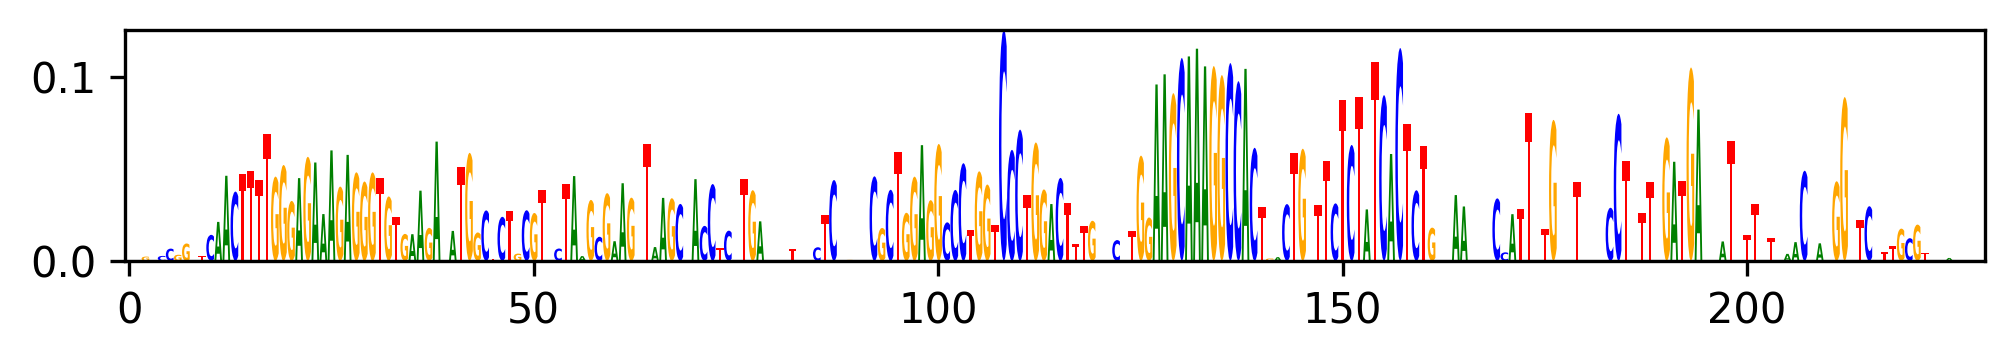

In [20]:
import logomaker

fig = plt.figure( figsize=(8, 1), dpi=300)
ax1 = fig.add_subplot(111)
# create Logo object
PWM_logo = logomaker.Logo(df_hypo_contri,
                        shade_below=.5,
                        fade_below=.5,
                        ax=ax1
                        )

# save contribution map as sequence logo png file
#plt.savefig("/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/example_contrib_map.png", dpi=300)
plt.show()


### Attribution maps for tf modisco
For tfmodisco it is recommended to mean normalize the contribution scores (https://github.com/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/Generate%20Importance%20Scores.ipynb). Note that this is rather a gut feeling from the developers than something that is proven (?). Also note that the mean normalization makes referencing to the reference predictions unnecessary (so why have we done it in the first place? Because this is how ISM in general is described everywhere...(https://www.nature.com/articles/s41576-022-00532-2) ).

In [21]:
scores_for_modisco=np.copy(scores)

# iterate over seqs
for i in range (0, scores_for_modisco.shape[0], 1):
        # iterate over base pos
        for j in range (0, scores_for_modisco.shape[1], 1):
                # center per sequence
                scores_for_modisco[i,j, :]=(scores_for_modisco[i,j,:])-np.mean(scores_for_modisco[i,j,:])
#np.savez("/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/scores_for_modisco.npz", hypothetical_contribution_scores)


Lets plot the mean normalized hypothetical scores used for tf modisco:

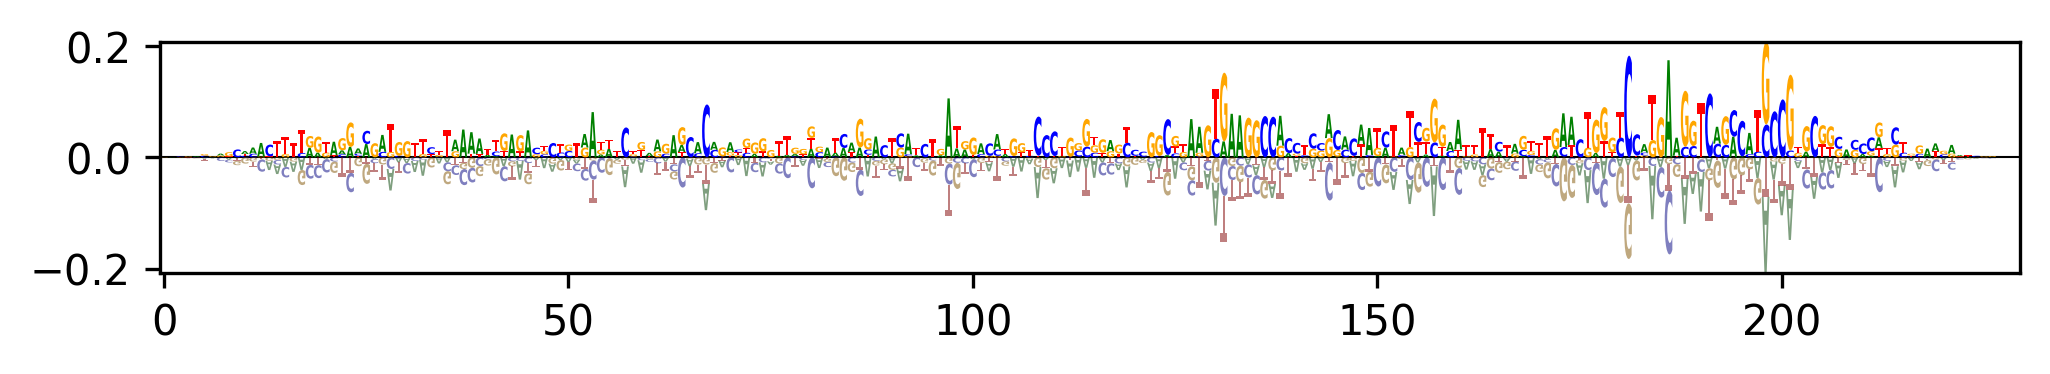

In [22]:
df_hypo_contri = pd.DataFrame(scores_for_modisco[2], columns=['A', 'C', 'G', 'T'])
fig = plt.figure( figsize=(8, 1), dpi=300)
ax1 = fig.add_subplot(111)
# create Logo object
PWM_logo = logomaker.Logo(df_hypo_contri,
                        shade_below=.5,
                        fade_below=.5,
                        ax=ax1
                        )

# save contribution map as sequence logo png file
#plt.savefig("/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/example_contrib_map.png", dpi=300)
plt.show()

and the actual contribution scores resulting from it:

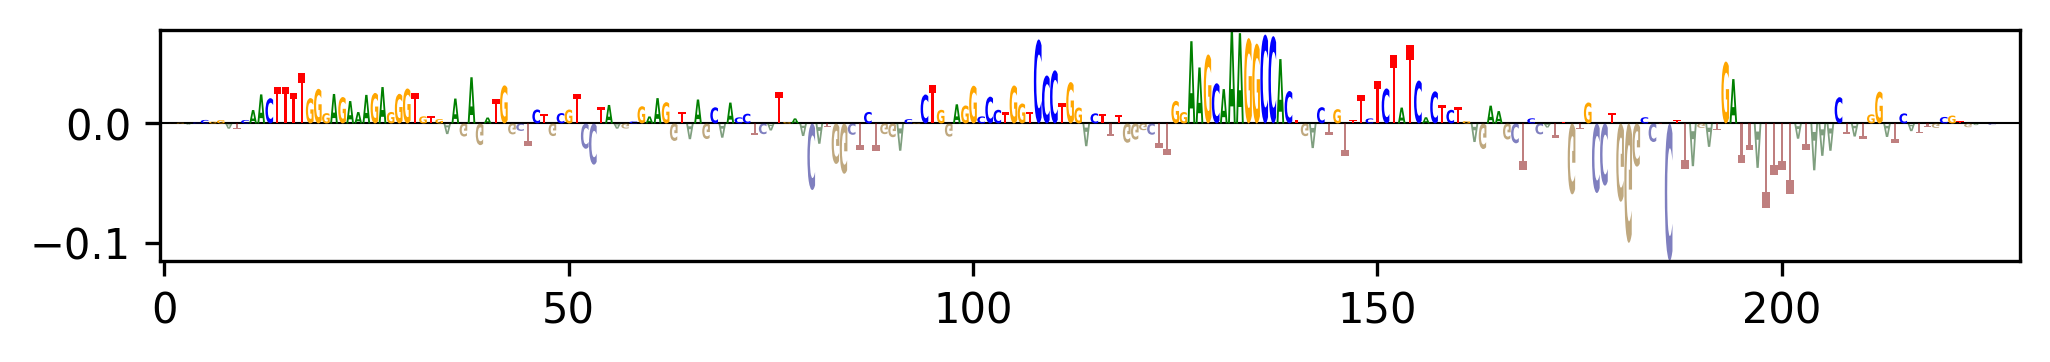

In [23]:
df_hypo_contri = pd.DataFrame(scores_for_modisco[2]*seqs[2], columns=['A', 'C', 'G', 'T'])
fig = plt.figure( figsize=(8, 1), dpi=300)
ax1 = fig.add_subplot(111)
# create Logo object
PWM_logo = logomaker.Logo(df_hypo_contri,
                        shade_below=.5,
                        fade_below=.5,
                        ax=ax1
                        )

# save contribution map as sequence logo png file
#plt.savefig("/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/example_contrib_map.png", dpi=300)
plt.show()

Note that both ways plotting actual contribution scores result from the same data and include very similar information.

# Using tfmodisco

## setting up the environment

now we can set up the environments

In [24]:
import modiscolite
import numpy as np
import h5py
import pandas as pd

## Running tf modisco
Above we have learned how you can look at and understand a model's representation of a given sequence. However, doing MPRAs, you will typicall end up with tens of thousands sequences and you don't want to look at each one individually. This is where you want to use tfmodisco. It will in a way give you a model representation of all your sequences.

Now that we have prepared all the arrays so that modisco can process them, we can finally run modisco and let it do it's magic :-). Note that the result depends a lot on the parameters that you use. E.g. `trim_to_window_size` and `initial_flank_to_add` will define how long the resulting motifs can be. Note that we again use only the first (few) sequence(s) of the data set to keep calculation times feasible. The output of the code below with the full set can again be found in the `/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data` folder.

In [25]:
#print(scores_for_modisco[2])
#print(seqs[2])

#modisco
pos_patterns, neg_patterns = modiscolite.tfmodisco.TFMoDISco(
        sliding_window_size=8,
        flank_size=8,
        min_metacluster_size=20,
        target_seqlet_fdr=0.1,
        hypothetical_contribs=scores_for_modisco,
        one_hot=seqs,
        max_seqlets_per_metacluster=20000,
        trim_to_window_size=10,#20
        n_leiden_runs=2,
        initial_flank_to_add=3,#5
        final_min_cluster_size=30,
        verbose=True)

#save results
#modiscolite.io.save_hdf5(str(contrib_file[0])+".h5", pos_patterns, neg_patterns)

#print pos and neg patterns; None or empty array if no patterns are identified.
print(pos_patterns)
print(neg_patterns)

None
None


Finally, we can run the command line verison of tfmodisco to generate a tfmodisco html report. The example below uses `/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/modisco_hypothetical_contribution_scores_all.npz.h5`as input file, so not only the 6 sequences that we used above. Note that I use here a slightly processed version of the JASPAR database. Its already present in the google drive folder we are working in but you could generate it using:
```
wget https://jaspar.genereg.net/download/data/2022/CORE/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt
cat JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt | awk '{{if ($1=="MOTIF") {{print $1,$2"_"$3,$3}} else {{print $0}}}}' > JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme_nice.txt
```
(credits to Max Schubach for this hack :-) ). It will make the tf modisco html report a bit more readable as you can see the motifs' names. Unfortunatelly, the following part does not seem to work in colab but should work on your local linux system.

In [ ]:
!modisco report \
-i /content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/modisco_hypothetical_contribution_scores_all.npz.h5 \
-o /content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/tfmodisco_report \
-s /content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/tfmodisco_report \
-m /content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme_nice.txt

After creating a copy of the file `motifs.html` in the directory above the output folder, we can explore the modisco results (doesn't work properly in this colab, sorry) :-).

In [ ]:
# demo example
#!cp /content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/tfmodisco_report/motifs.html /content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/motifs.html

# real example
!cp /content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/tfmodisco_report_MPRAultra_all/motifs.html /content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/motifs.html

In [ ]:
from IPython.display import HTML
HTML(filename='/content/drive/MyDrive/MPRA-IGVF-Workshop-2024/Tutorials/T3_MPRA_modeling_interpretation/data/motifs.html')

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo
pos_patterns.pattern_0,3592,,,MA0599.1_MA0599.1.KLF5,0.000020,,MA0685.2_MA0685.2.SP4,0.000020,,MA0079.5_MA0079.5.SP1,0.000026,
pos_patterns.pattern_1,2938,,,MA0474.3_MA0474.3.Erg,0.000051,,MA1956.1_MA1956.1.FOXO1::FLI1,0.000111,,MA0062.3_MA0062.3.GABPA,0.000111,
pos_patterns.pattern_2,1531,,,MA0036.3_MA0036.3.GATA2,0.001342,,MA1970.1_MA1970.1.TRPS1,0.001342,,MA1104.2_MA1104.2.GATA6,0.001342,
pos_patterns.pattern_3,1410,,,MA1644.1_MA1644.1.NFYC,0.000005,,MA0060.3_MA0060.3.NFYA,0.000100,,MA0502.2_MA0502.2.NFYB,0.055698,
pos_patterns.pattern_4,1298,,,MA1633.2_MA1633.2.BACH1,0.004738,,MA0835.2_MA0835.2.BATF3,0.004738,,MA1988.1_MA1988.1.Atf3,0.004738,
pos_patterns.pattern_5,1233,,,MA0643.1_MA0643.1.Esrrg,1.000000,,MA0160.2_MA0160.2.NR4A2,1.000000,,MA1581.1_MA1581.1.ZBTB6,1.000000,
pos_patterns.pattern_6,904,,,MA0833.2_MA0833.2.ATF4,0.000593,,MA1636.1_MA1636.1.CEBPG,0.001334,,MA1962.1_MA1962.1.POU2F1::SOX2,0.268047,
pos_patterns.pattern_7,507,,,MA1512.1_MA1512.1.KLF11,0.000483,,MA0746.2_MA0746.2.SP3,0.000516,,MA1517.1_MA1517.1.KLF6,0.000516,
pos_patterns.pattern_8,314,,,MA0093.3_MA0093.3.USF1,0.000019,,MA0831.3_MA0831.3.TFE3,0.000441,,MA0636.1_MA0636.1.BHLHE41,0.000441,
pos_patterns.pattern_9,285,,,MA0088.2_MA0088.2.ZNF143,1.000000,,MA1716.1_MA1716.1.ZNF76,1.000000,,MA0038.2_MA0038.2.GFI1,1.000000,
